Load CIFAR-10 dataset and split

In [17]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# This custom split is from the official training data and does not use the official testing data
generator = torch.Generator().manual_seed(7)
train_set, val_set, test_set = random_split(dataset, [0.8, 0.1, 0.1], generator=generator)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)

Min-Max Scaling to [-1,1]

In [18]:
def compute_min_max(dataloader):
    min_unscaled = float("inf")
    max_unscaled = float("-inf")
    for x, _ in dataloader:
        min_unscaled = min(min_unscaled, x.min().item())
        max_unscaled = max(max_unscaled, x.max().item())
    return min_unscaled, max_unscaled

class MinMaxScaling:
    def __init__(self, min_unscaled, max_unscaled, min_scaled, max_scaled):
        self.min_unscaled = min_unscaled
        self.max_unscaled = max_unscaled
        self.min_scaled = min_scaled
        self.max_scaled = max_scaled
    
    def __call__(self, x):
        return ((x-self.min_unscaled)/(self.max_unscaled-self.min_unscaled))*(self.max_scaled-self.min_scaled)+self.min_scaled

Apply the data transformations

In [19]:
data_min, data_max = compute_min_max(train_loader)
min_max_scaling = MinMaxScaling(data_min, data_max, -1, 1)

train_set.transform = transforms.Compose([
    transforms.ToTensor(),
    min_max_scaling
])

Preview the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.70980394..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8117647..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.77254903].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5058824..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.6313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.9

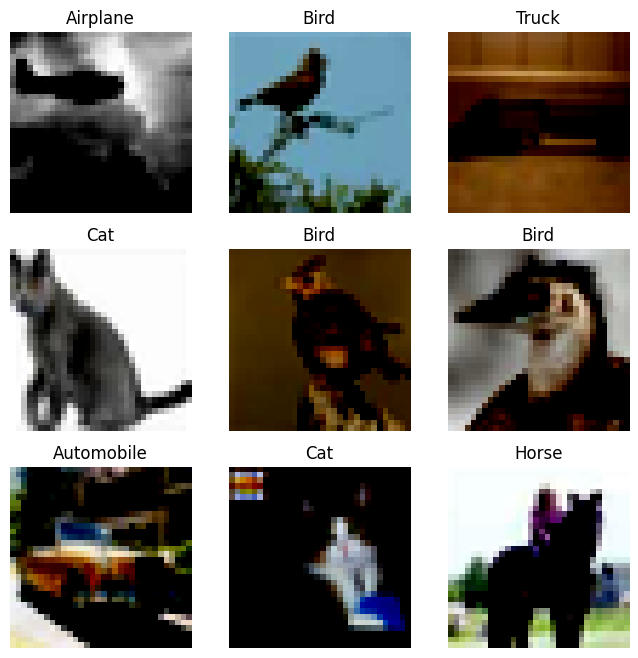

In [25]:
import matplotlib.pyplot as plt

labels = {
    0: "Airplane",
    1: "Automobile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck"
}

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows,cols,i)
    plt.title(labels[label])
    plt.axis("off")
    img = img.permute(1,2,0)
    plt.imshow(img.squeeze(), cmap="viridis")
plt.show()